In [1]:
import os
import json
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from apelfei.utils.data_handling import open_fits, load_adi_data
from apelfei.gaussianity.residual_tests import extract_circular_annulus
from apelfei.utils.general import center_subpixel

## This Code is about

This code computes the correlation of pixel values w.r.t its neighbours. This correlation seems to be different for different separations from the star. Moreover, it is dependent on the number of PCA components used. Since, we aim for independent noise observations this effect should be investigated in more detail in future work.

## Read the unsaturated PSF

In [2]:
# Use this setup to run the experiment on the non-stacked data
root_dir = "../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/"

In [3]:
dataset_json_file = os.path.join(root_dir, "dataset.json")
config_dir = os.path.join(root_dir, "configs_cmap")
algo_config_root = os.path.join(root_dir, "configs_algo")
residual_result_dir = os.path.join(root_dir, "pca_residuals")

with open(dataset_json_file) as json_file:
    tmp_dataset_config = json.load(json_file)

In [4]:
# we need the psf template for contrast calculation
science_data, _, raw_psf_template_data = load_adi_data(tmp_dataset_config["file_path"],
                                                       data_tag=tmp_dataset_config["stack_key"],
                                                       psf_template_tag=tmp_dataset_config["psf_template_key"],
                                                       para_tag=tmp_dataset_config["parang_key"])

dit_psf_template = tmp_dataset_config["dit_psf_template"]
dit_science = tmp_dataset_config["dit_science"]

In [5]:
crop_template = tmp_dataset_config["crop_template"]

psf_template_data = raw_psf_template_data[crop_template:-crop_template, 
                                          crop_template:-crop_template]

## Load the processed and rotated PCA residual stack

In [6]:
residual_stack_cADI = open_fits("../../../70_results/part1/ADI_residual_stacks/cADI_stack.fits")
residual_stack_PCA = open_fits("../../../70_results/part1/ADI_residual_stacks/30_PCA_stack.fits")

In [7]:
residual_stack_cADI = residual_stack_cADI.swapaxes(0, 2)
residual_stack_PCA = residual_stack_PCA.swapaxes(0, 2)

In [8]:
test_residual_frame = np.zeros_like(residual_stack_cADI[:, :, 0])

## Compute temporal correlations

In [9]:
residual_stack_cADI_reshape = residual_stack_cADI.reshape(
    residual_stack_cADI.shape[0]*residual_stack_cADI.shape[1], 
    residual_stack_cADI.shape[2])

residual_stack_PCA_reshape = residual_stack_PCA.reshape(
    residual_stack_PCA.shape[0]*residual_stack_PCA.shape[1], 
    residual_stack_PCA.shape[2])

In [10]:
correlation_map_cADI = np.matmul(residual_stack_cADI_reshape, 
                                 residual_stack_cADI_reshape.T)
correlation_map_PCA = np.matmul(residual_stack_PCA_reshape, 
                                residual_stack_PCA_reshape.T)

In [11]:
correlation_map_PCA = correlation_map_PCA.reshape(residual_stack_PCA.shape[0], residual_stack_PCA.shape[1],
                                                  residual_stack_PCA.shape[0], residual_stack_PCA.shape[1])

correlation_map_cADI = correlation_map_cADI.reshape(residual_stack_cADI.shape[0], residual_stack_cADI.shape[1],
                                                    residual_stack_cADI.shape[0], residual_stack_cADI.shape[1])

In [12]:
# Create two masks for the inner and outer region
_, positions_inner, mask = extract_circular_annulus(2, 4.2, test_residual_frame, annulus_width=1.)
_, positions_outer, mask = extract_circular_annulus(5, 4.2, test_residual_frame, annulus_width=1.)

## Compute the averaged Correlation maps

In [13]:
def compute_spatial_correlation(correlation_map_in,
                                positions_in):

    area_size = 11
    area_sum = np.zeros((2*area_size-1, 2*area_size-1))

    for tmp_position in positions_in:
        area_sum += correlation_map_in[tmp_position[0], tmp_position[1],
                                       tmp_position[0]-area_size+1:tmp_position[0]+area_size,+
                                       tmp_position[1]-area_size+1:tmp_position[1]+area_size]
        
    return area_sum

In [14]:
pca_inner_map = compute_spatial_correlation(correlation_map_PCA, positions_inner)
pca_outer_map = compute_spatial_correlation(correlation_map_PCA, positions_outer)
cadi_inner_map = compute_spatial_correlation(correlation_map_cADI, positions_inner)
cadi_outer_map = compute_spatial_correlation(correlation_map_cADI, positions_outer)

## Create the Plot

In [15]:
def plot_correlation(axis_in,
                     map_in):
    
    # Show the PSF
    axis_in.imshow(map_in, 
                   vmin=np.min(map_in), 
                   vmax=np.max(map_in)*0.9)

    # Remove the axis 
    axis_in.axes.get_xaxis().set_ticks([])
    axis_in.axes.get_yaxis().set_ticks([])

In [16]:
def plot_1d_line(axis_in,
                 map_in,
                 color_in,
                 label_in):
    
    tmp_line = deepcopy(map_in[:,10])
    tmp_line /= np.max(tmp_line)
    
    x_space = (np.linspace(0, 20, 21) - 10) / 3.8
    
    axis_in.plot(x_space, tmp_line,
                 lw=3,label=label_in,
                 color = color_in)
    
    axis_in.set_ylim(-0.4, 1.3)
    axis_in.set_xlim(np.min(x_space),
                     np.max(x_space))
    axis_in.set_xticks(np.arange(-2.5, 2.5, 0.5))
    axis_in.grid()

In [17]:
frame_center = center_subpixel(correlation_map_PCA[0, 0])

# draws a dashed cicle to mark the regions used
def draw_circle(axis_in,
                r_in, r_out):
    
    n, radii = 100, [r_in, r_out]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    #ax = plt.subplot(111, aspect='equal')
    axis_in.fill(np.ravel(xs)+frame_center[0],
                 np.ravel(ys)+frame_center[1], 
                 fc='white', ec = "none",alpha=0.1)
    axis_in.set_xlim(0, correlation_map_PCA[0, 0].shape[0]-1)
    axis_in.set_ylim(0, correlation_map_PCA[0, 0].shape[0]-1)
    
    circle = plt.Circle(frame_center, r_in, ls="--", ec='white', fc="none", alpha=0.5)
    axis_in.add_patch(circle)
    circle = plt.Circle(frame_center, r_out, ls="--", ec='white', fc="none", alpha=0.5)
    axis_in.add_patch(circle)
    axis_in.invert_yaxis()

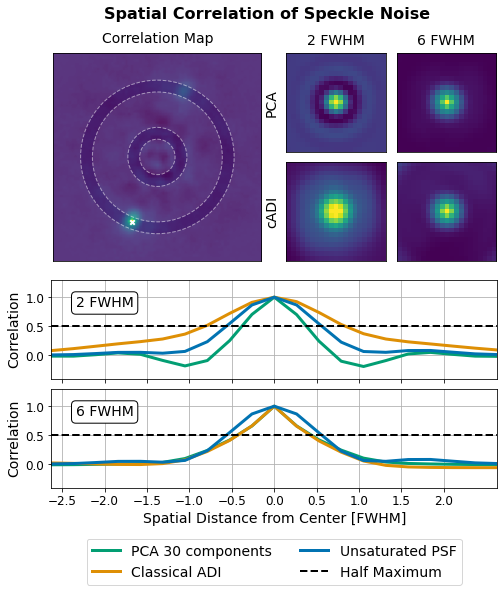

In [18]:
# 1.) Make the plot gridlayout 
fig = plt.figure(constrained_layout=False, 
                 figsize=(8, 8))
gs0 = fig.add_gridspec(2, 2, height_ratios=[1, 1])
gs0.update(hspace=0.09, wspace=0.1)

gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, 
                                       subplot_spec=gs0[0, 1],
                                       hspace=0.1, wspace=0.08,
                                       width_ratios=[1, 1])

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, 
                                       subplot_spec=gs0[1, :],
                                       hspace=0.1, wspace=0.1)

ax_correlation_example = fig.add_subplot(gs0[0, 0])
ax_pca_inner = fig.add_subplot(gs1[0, 0])
ax_pca_outer = fig.add_subplot(gs1[0, 1])
ax_cadi_inner = fig.add_subplot(gs1[1, 0])
ax_cadi_outer = fig.add_subplot(gs1[1, 1])

ax_illustration_inner = fig.add_subplot(gs2[0])
ax_illustration_outer = fig.add_subplot(gs2[1])

# Plot the correlation example
plot_correlation(ax_correlation_example, correlation_map_PCA[positions_outer[-42][0], 
                                                             positions_outer[-42][1]])

ax_correlation_example.scatter(positions_outer[-42][1],
                               positions_outer[-42][0],
                               marker="x", s=20, 
                               color="white", lw=2)

draw_circle(ax_correlation_example, 0, 4.2*1.5)
draw_circle(ax_correlation_example, 4.2*2.5, 4.2*5.5)
draw_circle(ax_correlation_example, 4.2*6.5, 4.2*20)

# Plot the averaged correlation maps
plot_correlation(ax_pca_inner, pca_inner_map)
plot_correlation(ax_pca_outer, pca_outer_map)
plot_correlation(ax_cadi_inner, cadi_inner_map)
plot_correlation(ax_cadi_outer, cadi_outer_map)

# Plot the 1D version
plot_1d_line(ax_illustration_inner, pca_inner_map, 
             sns.color_palette("colorblind")[2],
             "PCA 30 components")
plot_1d_line(ax_illustration_inner, cadi_inner_map - np.median(cadi_outer_map), 
             sns.color_palette("colorblind")[1],
             "Classical ADI")
plot_1d_line(ax_illustration_inner, psf_template_data, 
             sns.color_palette("colorblind")[0],
             "Unsaturated PSF")

plot_1d_line(ax_illustration_outer, pca_outer_map, 
             sns.color_palette("colorblind")[2],
             "PCA 30 components")
plot_1d_line(ax_illustration_outer, cadi_outer_map - np.median(cadi_outer_map), 
             sns.color_palette("colorblind")[1],
             "Classical ADI")
plot_1d_line(ax_illustration_outer, psf_template_data, 
             sns.color_palette("colorblind")[0],
             "Unsaturated PSF")

ax_illustration_inner.axhline(0.5, color="black", lw=2, 
                              ls="--", label="Half Maximum")
ax_illustration_outer.axhline(0.5, color="black", lw=2, 
                              ls="--", label="Half Maximum")

plt.setp(ax_illustration_inner.get_xticklabels(), visible=False)

# Labels
ax_pca_inner.set_title(r"2 FWHM",
                       fontsize=14,  y=1.02)
ax_pca_outer.set_title(r"6 FWHM",
                       fontsize=14,  y=1.02)

ax_pca_inner.set_ylabel(r"PCA",
                        fontsize=14)
ax_cadi_inner.set_ylabel(r"cADI",
                         fontsize=14)

ax_correlation_example.set_title(r"Correlation Map",
                                 fontsize=14,  y=1.02)

ax_illustration_outer.set_xlabel(r"Spatial Distance from Center [FWHM]",
                                 fontsize=14)

ax_illustration_inner.set_ylabel("Correlation",
                                 fontsize=14)

ax_illustration_outer.set_ylabel("Correlation",
                                 fontsize=14)

ax_illustration_inner.text(-2., 0.9, r"2 FWHM", 
                           va="center", ha="center", fontsize=14,
                           bbox=dict(facecolor='white',
                               boxstyle="round",
                               edgecolor="black"))

ax_illustration_outer.text(-2., 0.9, r"6 FWHM", 
                           va="center", ha="center", fontsize=14,
                           bbox=dict(facecolor='white',
                               boxstyle="round",
                               edgecolor="black"))
ax_illustration_inner.tick_params(axis='both', which='major', labelsize=12)
ax_illustration_outer.tick_params(axis='both', which='major', labelsize=12)

# Create the Legend
lgd = ax_illustration_outer.legend(ncol=2, fontsize=14, 
                                   loc='lower center',
                                   bbox_to_anchor=(0.5, -1.05))


st = fig.suptitle("Spatial Correlation of Speckle Noise", fontsize=16, fontweight="bold", y=0.96)

# Save the figure
fig.patch.set_facecolor('white')
plt.savefig("./15_Spatial_Correlation_of_Speckles.pdf", 
            bbox_extra_artists=(lgd, st), 
            bbox_inches='tight')